<a href="https://colab.research.google.com/github/adityapatil4141/new_project/blob/main/speech_recognition_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 7.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer


In [ ]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1",data_url,untar=True)

2748572632/2748572632 [==============================] - 130s 0us/step


#code:

In [ ]:
data_path

'/root/.keras/datasets/LJSpeech-1.1'

In [22]:
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

In [23]:
df = pd.read_csv(metadata_path,sep='|',header=None,quoting=3)

In [ ]:
metadata_path

'/root/.keras/datasets/LJSpeech-1.1/metadata.csv'

In [ ]:
df.head()

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


In [ ]:
df.rename(columns={0:"file_name",1:"transcription",2:"normalized_transcription"},inplace=True)

In [ ]:
df.head()

,file_name,transcription,normalized_transcription
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


In [ ]:
df.iloc[0,1]

'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'

In [ ]:
#df.columns=['file_name','transcription','normalized_transcription']

In [ ]:
# column transcription and normalized_transcription are smilar. just normalized column has full abveration (mr = mister)

In [ ]:
df=df[['file_name','normalized_transcription']]

In [ ]:
df=df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head(3)

,file_name,normalized_transcription
0,LJ021-0203,The course we have followed fits the American ...
1,LJ018-0207,The community of coiners of which he was so no...
2,LJ011-0187,"Returning to Carlisle, she now heard that her ..."


In [ ]:
split = int(len(df)*0.90)
df_train = df[:split]
df_test = df[split:]

In [ ]:
print(f"size of the training set: {len(df_train)}")
print(f"size of the training set: {len(df_test)}")

size of the training set: 11790
size of the training set: 1310


In [ ]:
characters = [x for x in "abcedfghijklmnopqrstuvwxyz'?!"]
char_to_num = keras.layers.StringLookup(vocabulary=characters,oov_token="")
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),oov_token="",invert= True)

print(char_to_num.get_vocabulary())
print(char_to_num.vocabulary_size())

['', 'a', 'b', 'c', 'e', 'd', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!']
30


In [ ]:
char_to_num

In [35]:
frame_length = 256
frame_step = 160
fft_length = 384

def encode_single_sample(wav_file,label):
  file = tf.io.read_file(wavs_path + wav_file +".wav")
  audio, _ = tf.audio.decode_wav(file)
  audio = tf.squeeze(audio,axis=1)
  audio = tf.cast(audio,tf.float32)

  spectrogram = tf.signal.stft(
      audio,frame_length=frame_length,frame_step=frame_step,fft_length=fft_length
  )
  spectrogram = tf.abs(spectrogram)
  spectrogram= tf.math.pow(spectrogram,0.5)

#normalization:
  means=tf.math.reduce_mean(spectrogram,1,keepdims=True)
  stddevs=tf.math.reduce_std(spectrogram,1,keepdims=True)
  spectrogram = (spectrogram-means)/(stddevs+1e-10)
  label = tf.strings.lower(label)
  label = tf.strings.unicode_split(label,input_encoding='UTF-8')
  label = char_to_num(label)
  return spectrogram,label



In [39]:
batch_size= 32
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train['file_name']),list(df_train['normalized_transcription']))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_test['file_name']),list(df_test['normalized_transcription']))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample,num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

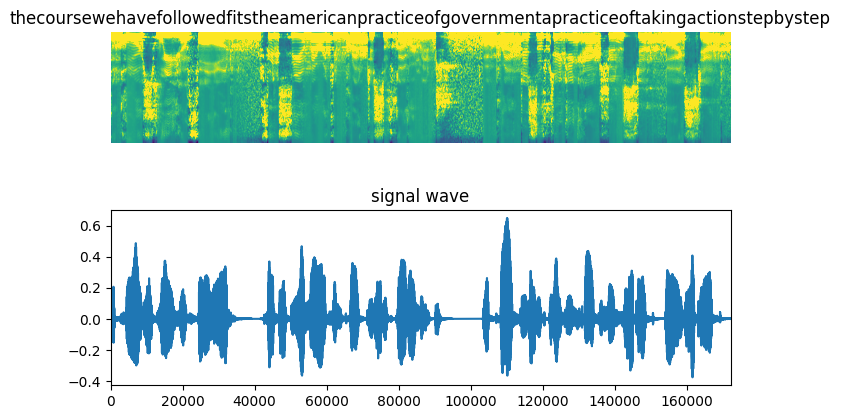

In [42]:
fig = plt.figure(figsize=(8,5))
for batch in train_dataset.take(1):
  spectrogram = batch[0][0].numpy()
  spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
  label = batch[1][0]

  label= tf.strings.reduce_join(num_to_char(label)).numpy().decode('UTF-8')
  ax = plt.subplot(2,1,1)
  ax.imshow(spectrogram,vmax=1)
  ax.set_title(label)
  ax.axis('off')

  file = tf.io.read_file(wavs_path +list(df_train['file_name'])[0]+".wav")
  audio,_ = tf.audio.decode_wav(file)
  audio = audio.numpy()
  ax = plt.subplot(2,1,2)
  plt.plot(audio)
  ax.set_title("signal wave")
  ax.set_xlim(0,len(audio))
  display.display(display.Audio(np.transpose(audio),rate=16000))
plt.show()

In [61]:
def CTCloss(y_true,y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0],dtype='int64')
  input_length = tf.cast(tf.shape(y_pred)[1],dtype='int64')
  label_length = tf.cast(tf.shape(y_true)[1],dtype='int64')

  input_lenght = input_length * tf.ones(shape=(batch_len,1),dtype='int64')
  label_lenght = label_length * tf.ones(shape=(batch_len,1),dtype='int64')

  loss = keras.backend.ctc_batch_cost(y_true,y_pred,input_length,label_length)
  return loss

In [62]:
def build_model(input_dim,output_dim,rnn_layers=5,rnn_units=128):
  input_spectrogram = layers.Input((None,input_dim),name='input')
  x= layers.Reshape((-1,input_dim,1),name="expand_dim")(input_spectrogram)
  c = layers.Conv2D(
      filters=32,
      kernel_size=[11,41],
      strides=[2,2],
      padding='same',
      use_bias=False,
      name='conv_1',
  )(x)
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11,21],
      strides=[1,2],
      padding='same',
      use_bias=False,
      name='conv_2'
  )(x)

  x = layers.BatchNormalization(name='conv_2_bn')(x)
  x = layers.ReLU(name='conv_2_relu')(x)

  x= layers.Reshape((-1,x.shape[-2]*x.shape[-1]))(x)

  for i in range(1,rnn_layers+1):
    recurrent = layers.GRU(
        units=rnn_units,
        activation='tanh',
        recurrent_activation='sigmoid',
        use_bias=True,
        return_sequences=True,
        reset_after=True,
        name=f"gru_{i}",
    )
    x = layers.Bidirectional(
        recurrent, name=f"bidirectional_{i}",merge_mode= 'concat'
    )(x)
    if i<rnn_layers:
      x = layers.Dropout(rate=0.5)(x)

    x = layers.Dense(units=rnn_units*2,name='dense_1')(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)


    output = layers.Dense(units=output_dim+1,activation='softmax')(x)

    model = keras.Model(input_spectrogram,output, name='DeepSpeech_2')

    opt = keras.optimizers.Adam(learning_rate=1e-4)

    model.compile(optimizer=opt,loss=CTCloss)
    return model

In [63]:
model = build_model(
    input_dim=fft_length//2+1,
    output_dim = char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary()

Model: "DeepSpeech_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 193)]       0         
                                                                 
 expand_dim (Reshape)        (None, None, 193, 1)      0         
                                                                 
 conv_2 (Conv2D)             (None, None, 97, 32)      7392      
                                                                 
 conv_2_bn (BatchNormalizat  (None, None, 97, 32)      128       
 ion)                                                            
                                                                 
 conv_2_relu (ReLU)          (None, None, 97, 32)      0         
                                                                 
 reshape_5 (Reshape)         (None, None, 3104)        0         
                                                      

In [64]:
epochs= 15
history = model.fit(
    train_dataset,
    validation_data= validation_dataset,
    epochs=epochs
)

Epoch 1/15


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "<ipython-input-61-f18edc4510a2>", line 9, in CTCloss  *
        loss = keras.backend.ctc_batch_cost(y_true,y_pred,input_length,label_length)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 7158, in ctc_batch_cost
        label_length = tf.cast(tf.squeeze(label_length, axis=-1), tf.int32)

    ValueError: squeeze_dims[0] not in [0,0). for '{{node CTCloss/Squeeze}} = Squeeze[T=DT_INT64, squeeze_dims=[-1]](CTCloss/Cast_2)' with input shapes: [].


In [ ]:
predictions = []

targets = []

for batch in validation_dataset:

X, y = batch

batch_predictions model.predict(X)

batch_predictions = decode_batch_predictions(batch_predictions)

predictions.extend(batch_predictions)

for label in y:

label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")

targets.append(label)

wer_score = wer(targets, predictions)

print("." 100)

print(f"Word Error Rate: {wer_score:.4f}")

print("-" 100)

for i in np.random.randint(8, len(predictions), 5):

print(f"Target : {targets[i]}")

print(f"Prediction: (predictions[i]}")

print(180)